In [ ]:
import numpy as np
import math
import re
import os
import time
from typing import List, Tuple

# Google Drive'a bağlan
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **Yardımcı Fonksiyonlar**

In [ ]:
def get_np_from_state_dict(state_dict, key):
    if key in state_dict:
        return state_dict[key].numpy().astype(np.float32)

    print(f"UYARI: Anahtar '{key}' state_dict'te bulunamadı.");
    return None

def softmax_np(x: np.ndarray, axis: int = -1) -> np.ndarray:
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

def relu_np(x: np.ndarray) -> np.ndarray:
    return np.maximum(0, x)

def gelu_approx_np(x: np.ndarray) -> np.ndarray:
    return 0.5 * x * (1 + np.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * np.power(x, 3))))

# **SINIFLAR**

# **WordTokenizer Sınıfı**
Bu sınıf, eğitim kodlamasındaki kadar kapsamlı olmayacak. Çünkü, sözlükler daha önce Pytorch tarafından gerçekleştirilen eğitimden sonra checkpoint'e kaydedildi ve çıkarım sürecinde bu sözlükler o checkpoint'lerden hazır olarak alınacak.

Bu sınıfın burada yapacağı iki şey;


1.   encoding: Kelimeleri sayısal indekslerine dönüştürmek
2.   decoding: Kelimeleri sayısal indekslerinden geri dönüştürmek



In [ ]:
class WordTokenizer:
    def __init__(self):
        self.word2idx = {} # Boş başlatılır, çünkü eğitimden (checkpoint) hazır gelecek
        self.idx2word = {} # Boş başlatılır, çünkü eğitimden (checkpoint) hazır gelecek
        self.vocab_size = 0

    def encode(self, sentence: str, add_sos_eos: bool = False) -> List[int]:
        tokens = [self.word2idx.get(word, self.word2idx['<unk>']) for word in sentence.lower().split()]
        if add_sos_eos: tokens = [self.word2idx['<sos>']] + tokens + [self.word2idx['<eos>']]
        return tokens

    def decode(self, indices: List[int]) -> str:
        return ' '.join([self.idx2word.get(idx, '<unk>') for idx in indices if idx not in [self.word2idx['<pad>'], self.word2idx['<sos>'], self.word2idx['<eos>']]])

# **Embedding Sınıfı**
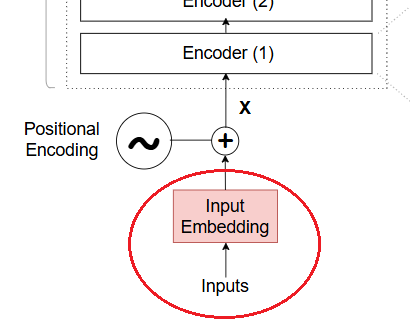

In [ ]:
class Embedding:
    def __init__(self, num_tokens: int, d_model: int, padding_idx: int = None):
        self.num_tokens = num_tokens # sözlükteki token sayısı
        self.d_model = d_model # modelin boyutu
        self.padding_idx = padding_idx # dolgu token'ının indeksi
        self.embedding_matrix: np.ndarray = None # (num_tokens, d_model) boyutlu

    def load_weights(self, weight: np.ndarray):
        if weight is None:
            raise ValueError("Embedding için ağırlık None olamaz.")

        self.embedding_matrix = weight # (num_tokens, d_model) boyutlu

        # gömme matrisinin padding_idx ile belirtilen satırındaki tüm değerler 0.0 yapılır
        if self.padding_idx is not None and 0 <= self.padding_idx < self.embedding_matrix.shape[0]:
            self.embedding_matrix[self.padding_idx] = 0.0

    def forward(self, input_ids: np.ndarray) -> np.ndarray:
        if self.embedding_matrix is None:
            raise ValueError("Embedding ağırlıkları yüklenmemiş.");

        return self.embedding_matrix[input_ids]

# **Linear Sınıfı**
Bu sınıf, transformer'daki tüm lineer işlemlerden (giriş/çıkış projeksiyonları ve FFN) sorumludur.

In [ ]:
class Linear:
    def __init__(self, num_features_in: int, num_features_out: int, use_bias: bool = True):
        self.num_features_in = num_features_in    # lineer katmanın giriş vektör boyu
        self.num_features_out = num_features_out  # lineer katmanın çıkış vektör boyu
        self.use_bias = use_bias  # bias'in olup olmadığı
        self.weight: np.ndarray = None
        self.bias: np.ndarray = None

    def load_weights(self, weight: np.ndarray, bias: np.ndarray = None):
        if weight is None:
            raise ValueError("Linear için ağırlık (weight) None olamaz.")

        self.weight = weight

        if self.use_bias:
            self.bias = bias if bias is not None else np.zeros(self.num_features_out, dtype=np.float32)

    def forward(self, x: np.ndarray) -> np.ndarray:
        if self.weight is None:
            raise ValueError("Linear ağırlıkları yüklenmemiş.")

        # x girdisini self.weight ağırlık matrisinin transpozu ile çarparak bir output üretir
        output = np.dot(x, self.weight.T)

        if self.use_bias and self.bias is not None:
            output = output + self.bias

        return output

# **LayerNorm Sınıfı**
Bu sınıf, encoder ve decoder'daki her bir alt katmandan sonra gerçekleştirilecek olan tüm normalizayonlardan sorumludur.

In [ ]:
class LayerNorm:
    def __init__(self, feature_dim: int, eps: float = 1e-5):
        self.feature_dim = feature_dim # d_model'a karşılık geliyor
        self.eps = eps
        self.gamma: np.ndarray = None
        self.beta: np.ndarray = None

    def load_weights(self, gamma: np.ndarray, beta: np.ndarray):
        if gamma is None or beta is None:
            raise ValueError("LayerNorm için gamma veya beta None olamaz.")

        self.gamma = gamma
        self.beta = beta

    def forward(self, x: np.ndarray) -> np.ndarray:
        if self.gamma is None or self.beta is None:
            raise ValueError("LayerNorm ağırlıkları yüklenmemiş.")

        # x: (batch_size, seq_len, d_model) boyutlu
        mean = np.mean(x, axis=-1, keepdims=True) # son eksenin (d_model) ortalaması ve (batch_size, seq_len, 1) boyutlu
        std = np.std(x, axis=-1, keepdims=True) # son eksenin (d_model) standart sapması ve (batch_size, seq_len, 1) boyutlu
        normalized = (x - mean) / (std + self.eps) # (batch_size, seq_len, d_model) boyutlu

        return self.gamma * normalized + self.beta # normalleştirilmiş girdi (x) ve (batch_size, seq_len, d_model) boyutlu

# **Droput Sınıfı**
Bu sınıf, normalde transformer'ın eğitim sırasında ezberlemesini (overfitting) engellemeden sorumludur ve çıkarımda kullanılmaz. Buraya göstermelik olarak konmuştur.

In [ ]:
class Dropout:
    def __init__(self, p: float = 0.1):
        self.p = p

    def forward(self, x: np.ndarray) -> np.ndarray:
        return x # inference aşamasında dropout uygulanmaz, aynen döndürüldü

# **MultiheadAttention Sınıfı**
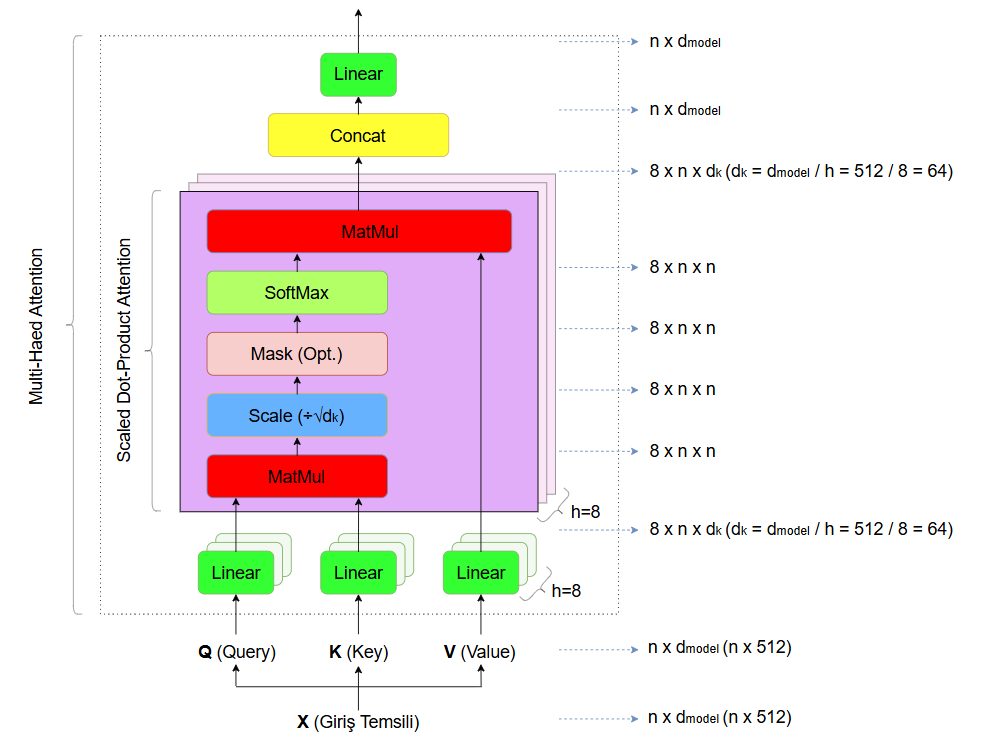

In [ ]:
class MultiheadAttention:
    def __init__(self, d_model: int, num_heads: int, dropout_p: float = 0.0, use_bias: bool = True):
        assert d_model % num_heads == 0, "d_model, num_heads'e tam bölünebilmeli."

        self.d_model = d_model
        self.num_heads = num_heads # makalede h
        self.head_dim = d_model // num_heads # makalede d_k

        # Q, K, V ve out projeksiyonlarının Linear sınıf örnekleri
        self.q_proj = Linear(d_model, d_model, use_bias=use_bias)
        self.k_proj = Linear(d_model, d_model, use_bias=use_bias)
        self.v_proj = Linear(d_model, d_model, use_bias=use_bias)
        self.out_proj = Linear(d_model, d_model, use_bias=use_bias)

    def load_weights_from_pytorch(self, state_dict, prefix: str):
        # Pytorch ağırlık ve bias matrislerini Q, K ve V için BİRLEŞİK olarak ele alıyor

        # MHA girişinin birleşik ağırlık matrisidir ve (3 * d_model, d_model) boyutludur
        in_proj_w = get_np_from_state_dict(state_dict, prefix + 'in_proj_weight')

        # MHA girişinin birleşik bias matrisidir ve (3 * d_model) boyutludur
        in_proj_b = get_np_from_state_dict(state_dict, prefix + 'in_proj_bias')

        # MHA concat'ten sonra gelen çıkışının birleşik ağırlık matrisidir ve (3 * d_model, d_model) boyutludur
        out_proj_w = get_np_from_state_dict(state_dict, prefix + 'out_proj.weight')

        # MHA concat'ten sonra gelen çıkışının birleşik bias matrisidir ve (3 * d_model) boyutludur
        out_proj_b = get_np_from_state_dict(state_dict, prefix + 'out_proj.bias')

        if in_proj_w is None or out_proj_w is None:
            raise ValueError(f"MHA ({prefix}) için in_proj_weight veya out_proj.weight bulunamadı.")

        # birleşik olan matrisler burada parçalanıyor
        q_w, k_w, v_w = np.split(in_proj_w, 3, axis=0)
        q_b, k_b, v_b = (None, None, None) # başlangıçta None

        if in_proj_b is not None:
            q_b, k_b, v_b = np.split(in_proj_b, 3, axis=0)

        # Q, K, V ve out nesnelerinin parametre yüklemeleri
        self.q_proj.load_weights(q_w, q_b)
        self.k_proj.load_weights(k_w, k_b)
        self.v_proj.load_weights(v_w, v_b)
        self.out_proj.load_weights(out_proj_w, out_proj_b)

    def forward(self, query: np.ndarray, key: np.ndarray, value: np.ndarray, attn_mask: np.ndarray = None, key_padding_mask: np.ndarray = None) -> np.ndarray:
        batch_size, seq_len_q, _ = query.shape
        seq_len_k = key.shape[1]
        seq_len_v = value.shape[1]

        # 1. Lineer Projeksiyonlar:
        # Gelen Q, K, V vektörlerini, katmanın eğitim aşamasında öğrendiği ağırlık matrisleriyle çarparak
        # dikkat mekanizması için yeni Q, K, V temsillerini oluşturur.
        # self.q_proj, self.k_proj, self.v_proj, daha önce tanımladığınız NumPy tabanlı Linear katman örnekleridir.
        # Her bir projeksiyonun çıktısı olan q, k, v matrisleri hala (batch_size, seq_len, d_model) boyutlarındadır.
        q = self.q_proj.forward(query)
        k = self.k_proj.forward(key)
        v = self.v_proj.forward(value)

        # her bir token için d_model boyutundaki vektörleri, her biri head_dim boyutunda olan num_heads kadar parçaya ayır
        # örnek olarak; d_model = 512 ve num_heads = 8 ise head_dim (makalede d_k) = 64 olur
        # reshape sonrası q, k, v matrislerinin yeni boyutları: (batch_size, seq_len_q, num_heads, head_dim)
        # .transpose(0, 2, 1, 3) ile her bir dikkat başlığı için dikkat hesaplamalarının paralel ve verimli yapılması sağlanır
        # .transpose(0, 2, 1, 3) sayesinde yeni boyut şekli (batch_size, num_heads, seq_len_q, head_dim) olur
        # bu sayede (seq_len_q, head_dim) şeklinin bir araya gelmesi sağlandı ki az sonra kolay işlem yapılabilsin
        q = q.reshape(batch_size, seq_len_q, self.num_heads, self.head_dim).transpose(0, 2, 1, 3)
        k = k.reshape(batch_size, seq_len_k, self.num_heads, self.head_dim).transpose(0, 2, 1, 3)
        v = v.reshape(batch_size, seq_len_v, self.num_heads, self.head_dim).transpose(0, 2, 1, 3)

        # ham skor matrisini hesapla
        scores = np.matmul(q, k.transpose(0, 1, 3, 2)) / math.sqrt(self.head_dim)

        # Aşağıdaki kod bloğunun temel amacı, verilen bir attn_mask varsa, bu maskeyi scores tensörünün boyutlarıyla
        # uyumlu hale getirmek ve ardından maskeyi skorlara ekleyerek istenmeyen dikkat bağlantılarını
        # (örneğin, decoder'da gelecekteki token'lara bakmayı veya padding token'larına dikkat etmeyi) engellemektir.
        # Bu, Multi-Head Attention'ın doğru çalışması için önemli bir adımdır.
        if attn_mask is not None:
            if attn_mask.ndim == 2: # attn_mask 2 boyutlu ise
                # maskenin başına yeni bir eksen ekleyerek onu 3 boyutlu hale getirir: (1, seq_len_q, seq_len_k)
                attn_mask = attn_mask[np.newaxis, :, :]

            # maskenin başına yeni bir eksen daha ekleyerek onu 4 boyutlu hale getirir: (1, 1, seq_len_q, seq_len_k)
            # çünkü, scores tensörü (batch_size, num_heads, seq_len_q, seq_len_k) boyutlarındadır
            # maskenin scores ile toplanabilmesi için boyutlarının uyumlu olması gerekir
            scores = scores + attn_mask[np.newaxis, :, :]

        # key_padding_mask varsa bu maske, anahtar (key) dizisindeki hangi pozisyonların dolgu token'ı olduğunu ve
        # dolayısıyla dikkat hesaplamalarında göz ardı edilmesi gerektiğini belirtir.
        if key_padding_mask is not None:
            # key_padding_mask (batch_size, seq_len_k) boyutlarındadır.
            # True değerleri dolgu token'larını, False değerleri ise gerçek token'ları gösterir.
            # np.where(koşul, x, y): Bu NumPy fonksiyonu, koşul'un True olduğu yerlere x değerini, False olduğu yerlere ise y değerini atar.
            # key_padding_mask'in şekli (batch_size, 1, 1, seq_len_k) olmalı ki scores ile toplama işlemi yapılabilsin
            float_mask = np.where(key_padding_mask[:, np.newaxis, np.newaxis, :], -np.inf, 0.0)
            scores = scores + float_mask

        # softmax normalizasyonu yapılarak dikkat matrisi elde edilir
        # burada scores (batch_size, num_heads, seq_len_q, seq_len_k) boyutludur
        # dolayısıyla attn_weights de (batch_size, num_heads, seq_len_q, seq_len_k) boyutlu olur
        attn_weights = softmax_np(scores, axis=-1)

        # softmax çıktısı v matrisi ile çarpılır
        # context (batch_size, num_heads, seq_len_q, seq_len_k) boyutludur
        context = np.matmul(attn_weights, v)

        # MHA'nın başlarında (batch_size, seq_len_q, d_model) yapısındaki tensörler
        # önce (batch_size, seq_len_q, num_heads, head_dim) yapısına dönüştürülmüş,
        # sonra da (seq_len_q, head_dim) şeklinin bir araya gelmesi için transpose yapılmıştı
        # burada yeniden orijinal haline, yani, (batch_size, seq_len_q, d_model) boyutuna döndürüyoruz
        context = context.transpose(0, 2, 1, 3).reshape(batch_size, seq_len_q, self.d_model)

        # son olarak, başlarda tanımladığımız out_proj nesnesine lineer projeksiyon (dönüşüm) uyguluyoruz
        output = self.out_proj.forward(context)

        return output

# **FeedForward Sınıfı**
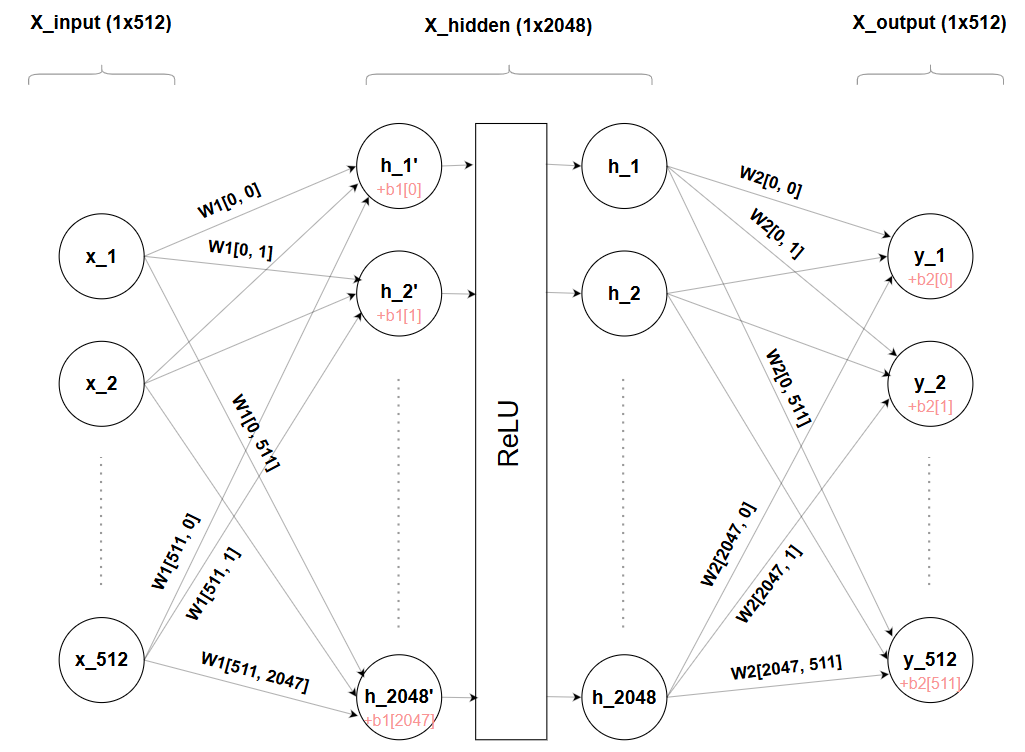

In [ ]:
class FeedForward:
    def __init__(self, d_model: int, dim_feedforward: int, dropout_p: float = 0.1, activation_str: str = "relu"):
        self.linear1 = Linear(d_model, dim_feedforward)
        self.dropout_ff = Dropout(dropout_p) # çıkarımda dropout uygulanmıyor, genel mantığı göstermesi için koydum
        self.linear2 = Linear(dim_feedforward, d_model)

        if activation_str == "relu": # makalede RELU var
            self.activation = relu_np
        elif activation_str == "gelu": # BERT, GPT'de kullanılıyor
            self.activation = gelu_approx_np
        else:
            raise ValueError(f"Desteklenmeyen aktivasyon: {activation_str}")

    def load_weights_from_pytorch(self, state_dict, prefix: str):
        # linear1 için ağırlık ve bias'ları al
        l1_weight = get_np_from_state_dict(state_dict, prefix + 'linear1.weight')
        l1_bias = get_np_from_state_dict(state_dict, prefix + 'linear1.bias')

        if l1_weight is not None: # Sadece ağırlık bile olsa yükle (bias olmasa da olur)
            self.linear1.load_weights(l1_weight, l1_bias)
        else:
            print(f"UYARI: {prefix}linear1.weight için ağırlık bulunamadı.")

        # linear2 için ağırlık ve bias'ları al
        l2_weight = get_np_from_state_dict(state_dict, prefix + 'linear2.weight')
        l2_bias = get_np_from_state_dict(state_dict, prefix + 'linear2.bias')

        if l2_weight is not None:
            self.linear2.load_weights(l2_weight, l2_bias)
        else:
            print(f"UYARI: {prefix}linear2.weight için ağırlık bulunamadı.")

    def forward(self, x: np.ndarray) -> np.ndarray:
        x = self.linear1.forward(x)
        x = self.activation(x)
        x = self.dropout_ff.forward(x) # inference'ta uygulanmaz (Dropout fonksiyonu x'i değiştirmiyor)
        x = self.linear2.forward(x)

        return x

# **PositionalEncoding Sınıfı**
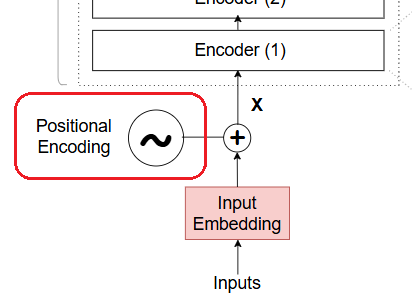

In [ ]:
class PositionalEncoding:
    def __init__(self, d_model: int, dropout_p: float = 0.1, max_len: int = 100):
        self.dropout = Dropout(dropout_p)

        # modelin işleyebileceği maksimum token sayısı (max_len) kadar satırdan ve
        # d_model kadar sütundan oluşan, başlangıç değerleri "0" olan bir matris oluştur
        pe = np.zeros((max_len, d_model), dtype=np.float32)

        # 0'dan max_len-1'e kadar olan tam sayıları içeren bir sütun vektörü oluştur
        # bu sıralı bilgiler pozisyon indeksleridir
        position = np.arange(0, max_len, dtype=np.float32).reshape(-1, 1)

        # bu satır, 1 / (10000^(2i/d_model)) terimini hesaplamada yaygın kullanılan bir yöntem
        div_term = np.exp(np.arange(0, d_model, 2, dtype=np.float32) * (-math.log(10000.0) / d_model))

        # pe matrisinin çift indeksli sütunlarına (0, 2, 4, ...) pozisyonel kodlamanın sinüs bileşenlerini ata
        pe[:, 0::2] = np.sin(position * div_term)

        # pe matrisinin tek indeksli sütunlarına (1, 3, 5, ...) pozisyonel kodlamanın kosinüs bileşenlerini ata
        if d_model % 2 != 0:
            pe[:, 1::2] = np.cos(position * div_term)[:,:d_model//2]
        else:
            pe[:, 1::2] = np.cos(position * div_term)

        # hesaplanan (max_len, d_model) boyutlu pe matrisinin başına yeni bir eksen ekle
        self.pe = pe[np.newaxis, :, :] # (1, max_len, d_model) boyutlu olur

    def forward(self, x: np.ndarray) -> np.ndarray:
        # x'in beklenen şekli: (batch_size, input_seq_len, d_model)
        # self.pe'nin __init__'te hesaplanan şekli: (1, max_len, d_model)

        input_seq_len = x.shape[1]             # Gelen girdinin dizi uzunluğu
        max_precomputed_len = self.pe.shape[1] # Önceden hesaplanmış PE'lerin max uzunluğu (max_len)

        # 1. Adım: Girdi dizisinin uzunluğunu kontrol et ve gerekirse kırp
        # Eğer gelen x dizisinin uzunluğu, pozisyonel kodlamaları önceden
        # hesapladığımız maksimum uzunluktan (max_precomputed_len) daha büyükse,
        # x dizisini bu maksimum uzunluğa kadar kırparız.
        # Bu, modelin bilmediği pozisyonlar için hata vermesini engeller.
        current_seq_len = input_seq_len
        if input_seq_len > max_precomputed_len:
            x = x[:, :max_precomputed_len, :]
            current_seq_len = max_precomputed_len # Kırpıldıktan sonraki dizi uzunluğu

        # 2. Adım: Pozisyonel kodlamaları al ve girdi embedding'lerine ekle
        # self.pe matrisinden, girdinin mevcut (veya kırpılmış) dizi uzunluğuna
        # (current_seq_len) kadar olan pozisyonel kodlamaları seçeriz.
        # self.pe'nin ilk boyutu (1), x'in batch_size'ı ile uyumlu hale gelir.
        positional_encodings_to_add = self.pe[:, :current_seq_len, :]

        # Token embedding'lerine (x) ilgili pozisyonel kodlamaları ekle.
        x_with_position = x + positional_encodings_to_add

        # 3. Adım: Dropout uygula
        # NumPy implementasyonumuzda Dropout sınıfının forward metodu
        # girdiyi değiştirmeden döndürdüğü için bu adım çıkarım sırasında etkisizdir.
        # Eğitim sırasında aşırı öğrenmeyi engellemek için kullanılır.
        output = self.dropout.forward(x_with_position)

        return output

# **EncoderLayer Sınıfı**
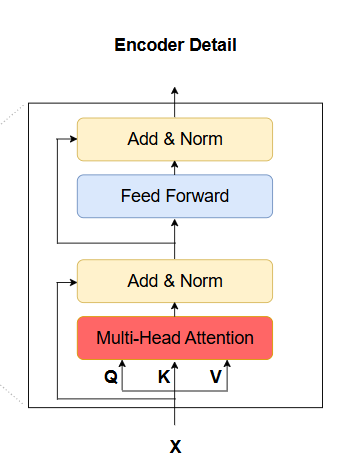

In [ ]:
class EncoderLayer:
    def __init__(self, d_model: int, nhead: int, dim_feedforward: int, dropout_p: float = 0.1, activation_fn_str: str = "relu"):
        self.self_attn = MultiheadAttention(d_model, nhead, dropout_p=dropout_p)
        self.feed_forward = FeedForward(d_model, dim_feedforward, dropout_p, activation_fn_str)
        self.norm1 = LayerNorm(d_model)
        self.norm2 = LayerNorm(d_model)
        self.dropout1 = Dropout(dropout_p)
        self.dropout2 = Dropout(dropout_p)

    def load_weights_from_pytorch(self, state_dict, prefix: str):
        self.self_attn.load_weights_from_pytorch(state_dict, prefix + 'self_attn.')
        self.feed_forward.load_weights_from_pytorch(state_dict, prefix)
        self.norm1.load_weights(get_np_from_state_dict(state_dict, prefix + 'norm1.weight'), get_np_from_state_dict(state_dict, prefix + 'norm1.bias'))
        self.norm2.load_weights(get_np_from_state_dict(state_dict, prefix + 'norm2.weight'), get_np_from_state_dict(state_dict, prefix + 'norm2.bias'))

    def forward(self, src: np.ndarray, src_mask: np.ndarray = None, src_key_padding_mask: np.ndarray = None) -> np.ndarray:
        attn_output = self.self_attn.forward(src, src, src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)
        src = src + self.dropout1.forward(attn_output); src = self.norm1.forward(src)
        ff_output = self.feed_forward.forward(src); src = src + self.dropout2.forward(ff_output); src = self.norm2.forward(src)
        return src

# **EncoderStack Sınıfı**
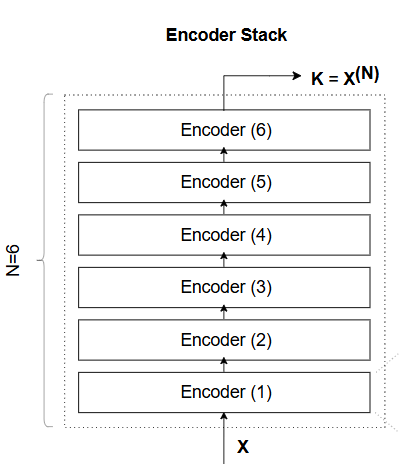

In [ ]:
class EncoderStack: # Önceden NumPyEncoderStack
    def __init__(self, d_model: int, nhead: int, dim_feedforward: int, num_layers: int, dropout: float, activation_fn_str: str):
        # num_layers sayısı kadar EncoderLayer örneği oluşturur ve bunları self.layers adlı bir listede saklar
        self.layers = [EncoderLayer(d_model, nhead, dim_feedforward, dropout, activation_fn_str) for _ in range(num_layers)]

        # Eğer yığında en az bir katman varsa (num_layers > 0),
        # tüm enkoder katmanlarından sonra uygulanacak bir LayerNorm (katman normalizasyonu) katmanı oluşturur ve self.norm'a atar.
        self.norm = LayerNorm(d_model) if num_layers > 0 else None

    def load_weights_from_pytorch(self, state_dict, prefix: str):
        for i, layer in enumerate(self.layers):
            layer.load_weights_from_pytorch(state_dict, prefix + f'layers.{i}.')

        if self.norm:
            self.norm.load_weights(get_np_from_state_dict(state_dict, prefix + 'norm.weight'), get_np_from_state_dict(state_dict, prefix + 'norm.bias'))

    def forward(self, src: np.ndarray, mask: np.ndarray = None, src_key_padding_mask: np.ndarray = None) -> np.ndarray:
        output = src

        for layer in self.layers:
            output = layer.forward(output, src_mask=mask, src_key_padding_mask=src_key_padding_mask)

        if self.norm: output = self.norm.forward(output)

        return output

# **DecoderLayer Sınıfı**
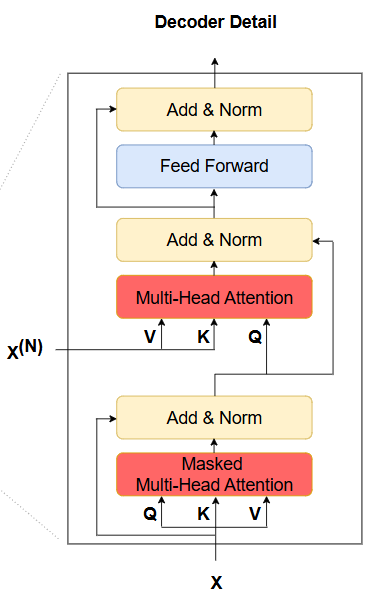

In [ ]:
class DecoderLayer:
    def __init__(self, d_model: int, nhead: int, dim_feedforward: int, dropout_p: float = 0.1, activation_fn_str: str = "relu"):
        self.self_attn = MultiheadAttention(d_model, nhead, dropout_p=dropout_p)
        self.multihead_attn = MultiheadAttention(d_model, nhead, dropout_p=dropout_p) # Cross-attention için
        self.feed_forward = FeedForward(d_model, dim_feedforward, dropout_p, activation_fn_str)
        self.norm1 = LayerNorm(d_model); self.norm2 = LayerNorm(d_model); self.norm3 = LayerNorm(d_model)
        self.dropout1 = Dropout(dropout_p); self.dropout2 = Dropout(dropout_p); self.dropout3 = Dropout(dropout_p)

    def load_weights_from_pytorch(self, state_dict, prefix: str):
        self.self_attn.load_weights_from_pytorch(state_dict, prefix + 'self_attn.')
        self.multihead_attn.load_weights_from_pytorch(state_dict, prefix + 'multihead_attn.') # PyTorch'taki cross-attention genellikle 'multihead_attn' olarak adlandırılır.
        self.feed_forward.load_weights_from_pytorch(state_dict, prefix)
        self.norm1.load_weights(get_np_from_state_dict(state_dict, prefix + 'norm1.weight'), get_np_from_state_dict(state_dict, prefix + 'norm1.bias'))
        self.norm2.load_weights(get_np_from_state_dict(state_dict, prefix + 'norm2.weight'), get_np_from_state_dict(state_dict, prefix + 'norm2.bias'))
        self.norm3.load_weights(get_np_from_state_dict(state_dict, prefix + 'norm3.weight'), get_np_from_state_dict(state_dict, prefix + 'norm3.bias'))

    def forward(self, tgt: np.ndarray, memory: np.ndarray, tgt_mask: np.ndarray = None, memory_mask: np.ndarray = None, tgt_key_padding_mask: np.ndarray = None, memory_key_padding_mask: np.ndarray = None) -> np.ndarray:
        self_attn_output = self.self_attn.forward(tgt, tgt, tgt, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask)
        tgt = tgt + self.dropout1.forward(self_attn_output); tgt = self.norm1.forward(tgt)
        cross_attn_output = self.multihead_attn.forward(tgt, memory, memory, attn_mask=memory_mask, key_padding_mask=memory_key_padding_mask)
        tgt = tgt + self.dropout2.forward(cross_attn_output); tgt = self.norm2.forward(tgt)
        ff_output = self.feed_forward.forward(tgt); tgt = tgt + self.dropout3.forward(ff_output); tgt = self.norm3.forward(tgt)
        return tgt

# **DecoderStack Sınıfı**
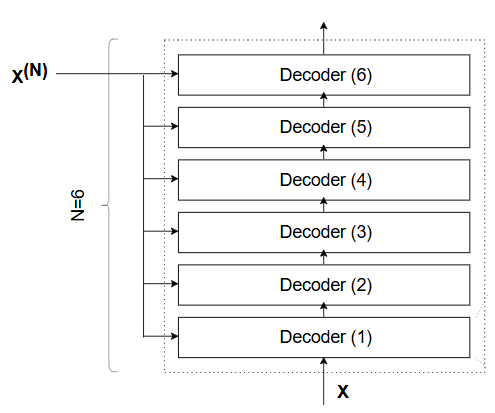

In [ ]:
class DecoderStack:
    def __init__(self, d_model: int, nhead: int, dim_feedforward: int, num_layers: int, dropout: float, activation_fn_str: str):
        self.layers = [DecoderLayer(d_model, nhead, dim_feedforward, dropout, activation_fn_str) for _ in range(num_layers)]
        self.norm = LayerNorm(d_model) if num_layers > 0 else None

    def load_weights_from_pytorch(self, state_dict, prefix: str):
        for i, layer in enumerate(self.layers):
            layer.load_weights_from_pytorch(state_dict, prefix + f'layers.{i}.')

        if self.norm:
            self.norm.load_weights(get_np_from_state_dict(state_dict, prefix + 'norm.weight'), get_np_from_state_dict(state_dict, prefix + 'norm.bias'))

    def forward(self, tgt: np.ndarray, memory: np.ndarray, tgt_mask: np.ndarray = None, memory_mask: np.ndarray = None, tgt_key_padding_mask: np.ndarray = None, memory_key_padding_mask: np.ndarray = None) -> np.ndarray:
        output = tgt

        for layer in self.layers:
            output = layer.forward(output, memory, tgt_mask, memory_mask, tgt_key_padding_mask, memory_key_padding_mask)

        if self.norm:
            output = self.norm.forward(output)

        return output

# **Transformer Sınıfı**
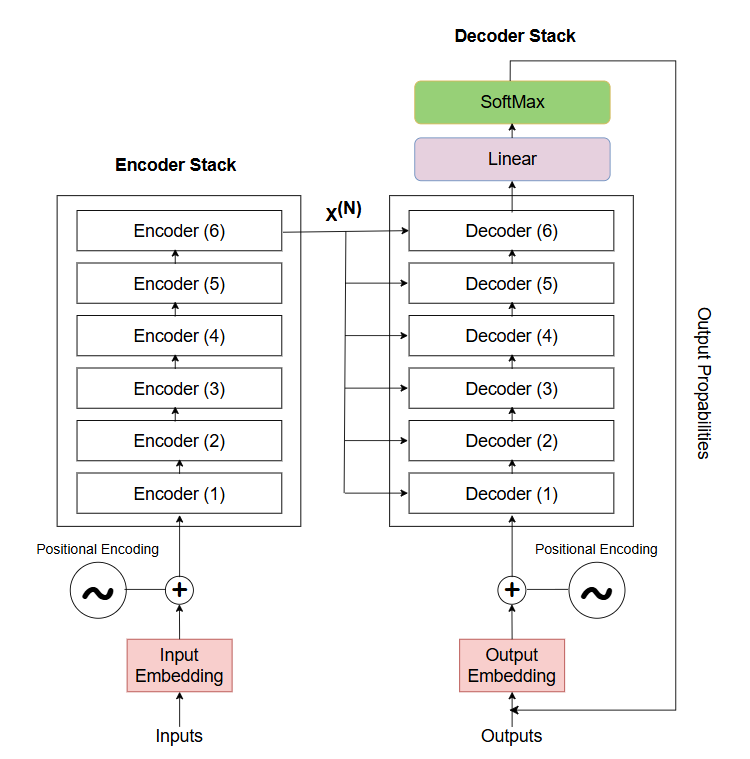

In [ ]:
class Transformer:
    def __init__(self, src_vocab_size: int, trg_vocab_size: int, src_pad_idx: int, trg_pad_idx: int,
                 d_model: int, nhead: int, num_encoder_layers: int, num_decoder_layers: int,
                 dim_feedforward: int, dropout: float, activation_fn_str: str, max_seq_len: int):

        self.d_model = d_model
        self.src_embedding = Embedding(src_vocab_size, d_model, padding_idx=src_pad_idx)
        self.trg_embedding = Embedding(trg_vocab_size, d_model, padding_idx=trg_pad_idx)
        self.pos_encoder = PositionalEncoding(d_model, dropout, max_len=max_seq_len)

        self.encoder = EncoderStack(d_model, nhead, dim_feedforward, num_encoder_layers, dropout, activation_fn_str)
        self.decoder = DecoderStack(d_model, nhead, dim_feedforward, num_decoder_layers, dropout, activation_fn_str)

        self.fc_out = Linear(d_model, trg_vocab_size)

    def load_weights_from_pytorch_state_dict(self, state_dict):
        print("Transformer: Ağırlıklar yükleniyor...")
        self.src_embedding.load_weights(get_np_from_state_dict(state_dict, 'src_embedding.embedding.weight'))
        self.trg_embedding.load_weights(get_np_from_state_dict(state_dict, 'trg_embedding.embedding.weight'))

        self.encoder.load_weights_from_pytorch(state_dict, 'transformer.encoder.')
        self.decoder.load_weights_from_pytorch(state_dict, 'transformer.decoder.')

        self.fc_out.load_weights(get_np_from_state_dict(state_dict, 'fc_out.weight'), get_np_from_state_dict(state_dict, 'fc_out.bias'))
        print("Transformer: Ağırlık yükleme tamamlandı.")

    def generate_square_subsequent_mask(self, sz: int) -> np.ndarray:
        # decoder tarafındaki kendi self-attention mekanizmasında kullanılan
        # kare ardışık maske (square subsequent mask) veya ileriye bakma maskesi (look-ahead mask) oluşturur.
        # İşlevi, bir dizideki belirli bir pozisyonun, dikkat hesaplaması sırasında
        # kendisinden sonraki pozisyonlara "bakmasını" veya onlardan bilgi almasını engellemektir.
        # Bu, özellikle metin üretimi gibi otoregresif görevlerde önemlidir,
        # çünkü bir sonraki kelimeyi tahmin ederken modelin gelecekteki kelimeleri görmemesi gerekir.

        # np.full((sz, sz), -np.inf, dtype=np.float32) ifadesi bir kenar uzunluğu sz kadar ve tüm değerleri -∞ olan bir kare matrisi oluşturur
        # np.triu(m, k): NumPy'nin bir matrisin üst üçgenini (upper triangle) döndüren fonksiyonudur.
        # m: shape ve k=esas alınacak köşekendir.
        # matrisin sol üst kenarından sağ alt kenarına çizilen doğru ana köşegen (k=0) sayılıyor.
        # k=1 köşgeni, k=0 köşegeninin bir üstündeki köşegendir.
        # matrisin k değerinin üstündeki değerler -∞ olarak korunurken altındaki değerler sıfırlanır.

        # örneğin, sz = 3 için sonuç matrisi (mask) şöyle olur:

        # mask = np.array([[  0., -np.inf, -np.inf],
        #                  [  0.,    0.,   -np.inf],
        #                  [  0.,    0.,      0.  ]], dtype=np.float32)

        mask = np.triu(np.full((sz, sz), -np.inf, dtype=np.float32), k=1)

        return mask

# **Ana Çıkarım Fonksiyonları**

In [ ]:
def translate_sentence_np(
    model_instance: Transformer,
    sentence_str: str,
    src_tokenizer_inf: WordTokenizer,
    trg_tokenizer_inf: WordTokenizer,
    max_len_config: int
):

    # giriş cümlesi (sentence_str) temizlenir
    cleaned_sentence = re.sub(r'[^\w\s\'-]', '', sentence_str).strip().lower()

    # temizlenmiş cümle Tokenizer kullanılarak token ID'lerine (sayısal temsillere) dönüştürülür
    src_tokens_ids_list = src_tokenizer_inf.encode(cleaned_sentence, add_sos_eos=True)

    # Eğer token ID listesinin uzunluğu, izin verilen maksimum uzunluktan (max_len_config) fazlaysa, cümle kısaltılır
    if len(src_tokens_ids_list) > max_len_config:
        src_tokens_ids_list = src_tokens_ids_list[:max_len_config-1] + [src_tokenizer_inf.word2idx['<eos>']]

    # Kaynak token ID listesi, NumPy dizisine (tensöre) dönüştürülür.
    src_tensor_np = np.array([src_tokens_ids_list], dtype=np.int64)

    # Token ID'leri, modelin gömme katmanından geçirilerek ham gömme vektörleri elde edilir
    src_emb_raw = model_instance.src_embedding.forward(src_tensor_np)

    # Gömme vektörleri, modelin boyutu (d_model) ile ölçeklenir (Transformer'larda yaygın bir tekniktir)
    src_emb = src_emb_raw * math.sqrt(model_instance.d_model)

    # Ölçeklenmiş gömme vektörlerine pozisyonel bilgiler eklenir. Bu, modelin kelimelerin sırasını anlamasını sağlar.
    src_emb_pos = model_instance.pos_encoder.forward(src_emb)

    # Kaynak tensörde <pad> (dolgu) token'larının olduğu yerleri işaretleyen bir maske oluşturulur.
    # Bu, dikkat mekanizmalarının dolgu token'larını dikkate almamasını sağlar.
    src_key_padding_mask_np = (src_tensor_np == src_tokenizer_inf.word2idx['<pad>'])

    # Hazırlanan pozisyonel gömme vektörleri ve dolgu maskesi, modelin enkoder (kodlayıcı) kısmına verilir.
    # Enkoder, kaynak cümlenin bir temsilini (memory) üretir. Bu memory, dekoder tarafından çeviri sırasında kullanılacaktır.
    memory = model_instance.encoder.forward(src_emb_pos, src_key_padding_mask=src_key_padding_mask_np)


    # Hedef Cümlenin Adım Adım Üretilmesi (Otoregresif Kod Çözme)

    # Hedef token ID listesi, hedef dilin <sos> token'ı ile başlatılır. Çeviri bu token ile başlar.
    trg_ids_list = [trg_tokenizer_inf.word2idx['<sos>']]

    # Maksimum hedef cümle uzunluğu kadar döngü çalışır. Her adımda bir sonraki kelime tahmin edilir.
    for _ in range(max_len_config):
        # O ana kadar üretilmiş hedef token ID'leri NumPy tensörüne dönüştürülür.
        trg_tensor_np = np.array([trg_ids_list], dtype=np.int64)

        # Mevcut hedef dizinin uzunluğu alınır.
        trg_seq_len = trg_tensor_np.shape[1]

        # Hedef dizi için bir ardışık maske (causal mask / look-ahead mask) oluşturulur.
        # Bu maske, dekoderin bir kelimeyi tahmin ederken sadece o ana kadar
        # üretilmiş kelimelere bakmasını sağlar, gelecekteki kelimeleri görmesini engeller.
        trg_causal_mask_np = model_instance.generate_square_subsequent_mask(trg_seq_len)

        # Hedef tensör için değerleri True/False olan dolgu maskesi oluşturulur.
        trg_key_padding_mask_np = (trg_tensor_np == trg_tokenizer_inf.word2idx['<pad>'])

        # Hedef token'lar için de kaynak taraftaki ile aynı şekilde
        # sırasıyla; gömme, ölçekleme ve pozisyonel kodlama işlemleri yapılır
        trg_emb_raw = model_instance.trg_embedding.forward(trg_tensor_np)
        trg_emb = trg_emb_raw * math.sqrt(model_instance.d_model)
        trg_emb_pos = model_instance.pos_encoder.forward(trg_emb)

        # Hazırlanan hedef gömme vektörleri, enkoderden gelen memory, ardışık maske (tgt_mask),
        # hedef dolgu maskesi (tgt_key_padding_mask) ve
        # kaynak dolgu maskesi (memory_key_padding_mask) modelin dekoder (kod çözücü) kısmına verilir.
        output_decoder = model_instance.decoder.forward(
            trg_emb_pos, memory,
            tgt_mask=trg_causal_mask_np,
            tgt_key_padding_mask=trg_key_padding_mask_np,
            memory_key_padding_mask=src_key_padding_mask_np
        )

        # Dekoder çıktısının sadece son token'a ait olan kısmı alınır (çünkü bir sonraki kelimeyi tahmin ediyoruz)
        # ve modelin son lineer katmanından (fc_out) geçirilerek logit değerleri elde edilir.
        # Logit'ler, hedef kelime dağarcığındaki her kelime için bir skordur.
        # output_decoder (batch_size, target_sequence_length, d_model) boyutlarındadır.
        logits = model_instance.fc_out.forward(output_decoder[:, -1, :])

        # En yüksek logit değerine sahip olan token ID'si seçilir
        # bu GREEDY DECODING adı verilen basit bir yöntemdir ve gerçek uygulamalarda genellikle BEAM SEARCH yöntemi kullanılır
        # Bu, tahmin edilen bir sonraki kelimenin ID'sidir.
        pred_token_id = np.argmax(logits, axis=-1)[0]

        # Tahmin edilen token ID'si, hedef token listesine eklenir.
        trg_ids_list.append(pred_token_id)

        # Eğer tahmin edilen token <eos> (cümle sonu) ise, çeviri tamamlanmış demektir ve döngüden çıkılır.
        if pred_token_id == trg_tokenizer_inf.word2idx['<eos>']:
            break

    # Üretilen hedef token ID listesi, trg_tokenizer_inf (hedef dil tokenizer'ı) kullanılarak
    # tekrar okunabilir bir cümleye dönüştürülür ve fonksiyonun çıktısı olarak döndürülür.
    return trg_tokenizer_inf.decode(trg_ids_list)

# **Ana Çıkarım Döngüsü**

In [ ]:
def main_inference_loop():
    DRIVE_BASE_PATH = '/content/drive/My Drive/transformer/'
    MODEL_CHECKPOINT_DIR_NAME = 'model_checkpoints'
    LAST_CHECKPOINT_FILE_NAME = 'last_checkpoint_512.pth' # Veya BEST_MODEL_FILE_NAME
    CHECKPOINT_TO_LOAD = os.path.join(DRIVE_BASE_PATH, MODEL_CHECKPOINT_DIR_NAME, LAST_CHECKPOINT_FILE_NAME)

    print(f"NumPy Çıkarımı için hedef checkpoint: {CHECKPOINT_TO_LOAD}")
    config_for_model = {}
    src_tokenizer_loaded = WordTokenizer()
    trg_tokenizer_loaded = WordTokenizer()

    try:
        import torch # Sadece config ve tokenizer yüklemek için
        print(f"Yapılandırma ve tokenizer için checkpoint yükleniyor...")
        if not os.path.exists(CHECKPOINT_TO_LOAD):
            print(f"HATA: Checkpoint bulunamadı: {CHECKPOINT_TO_LOAD}")
            return
        pt_checkpoint = torch.load(CHECKPOINT_TO_LOAD, map_location='cpu')

        src_tokenizer_loaded.word2idx = pt_checkpoint['src_word2idx']
        src_tokenizer_loaded.idx2word = {v:k for k,v in src_tokenizer_loaded.word2idx.items()}
        src_tokenizer_loaded.vocab_size = len(src_tokenizer_loaded.word2idx)

        trg_tokenizer_loaded.word2idx = pt_checkpoint['trg_word2idx']
        trg_tokenizer_loaded.idx2word = {v:k for k,v in trg_tokenizer_loaded.word2idx.items()}
        trg_tokenizer_loaded.vocab_size = len(trg_tokenizer_loaded.word2idx)

        # DÜZELTME: Checkpoint'ten 'pad_idx' oku
        pad_idx_from_checkpoint = pt_checkpoint.get('pad_idx', src_tokenizer_loaded.word2idx.get('<pad>', 0)) # Varsayılan <pad> indeksi 0

        config_for_model = {
            'd_model': pt_checkpoint['d_model'],
            'nhead': pt_checkpoint['nhead'],
            'num_encoder_layers': pt_checkpoint['num_encoder_layers'],
            'num_decoder_layers': pt_checkpoint['num_decoder_layers'],
            'dim_feedforward': pt_checkpoint['dim_feedforward'],
            'dropout': pt_checkpoint['dropout'], # Çıkarımda dropout NumPy'de etkisiz
            'activation_fn_str': pt_checkpoint.get('activation_fn_str', "relu"),
            'max_seq_len': pt_checkpoint.get('max_seq_len', 50),
            'src_pad_idx': pad_idx_from_checkpoint, # Düzeltilmiş pad_idx
            'trg_pad_idx': pad_idx_from_checkpoint  # Düzeltilmiş pad_idx
        }
        print("Yapılandırma ve tokenizer'lar başarıyla yüklendi.")

        numpy_model = Transformer(
            src_vocab_size=src_tokenizer_loaded.vocab_size,
            trg_vocab_size=trg_tokenizer_loaded.vocab_size,
            **config_for_model
        )

        # state_dict'in kendisi model ağırlıklarını içerir
        state_dict_for_numpy = pt_checkpoint['model_state_dict']
        numpy_model.load_weights_from_pytorch_state_dict(state_dict_for_numpy)

        del pt_checkpoint, state_dict_for_numpy, torch # Belleği boşalt
        import gc
        gc.collect()

    except ImportError:
        print("HATA: PyTorch kütüphanesi bulunamadı. Checkpoint yüklenemiyor.")
        return
    except Exception as e:
        print(f"Başlatma hatası: {e}")
        import traceback
        traceback.print_exc()
        return

    print("\nNumPy Tabanlı Çeviri Modeli Hazır.");
    print('Çıkmak için "exit", "quit", "çıkış" ya da "kapat" yazabilirsiniz.')

    while True:
        try:
            input_sentence = input("\nİngilizce cümle girin: ")
            if input_sentence.lower() in ["exit", "quit", "çıkış", "kapat"]:
                print("\nÇıktınız...")
                break
            if not input_sentence.strip():
                continue

            translated_sentence = translate_sentence_np(
                numpy_model, input_sentence,
                src_tokenizer_loaded, trg_tokenizer_loaded,
                config_for_model['max_seq_len']
            )
            print(f"Model Çevirisi    : {translated_sentence}")
        except KeyboardInterrupt:
            print("\nÇıktınız...")
            break
        except Exception as e:
            print(f"Çeviri hatası: {e}")
            # import traceback; traceback.print_exc() # Detaylı hata için gerekirse açılabilir

# **PROGRAMIN ANA KISMI**

In [ ]:
if __name__ == '__main__':
    main_inference_loop()

NumPy Çıkarımı için hedef checkpoint: /content/drive/My Drive/transformer/model_checkpoints/last_checkpoint_512.pth
Yapılandırma ve tokenizer için checkpoint yükleniyor...
Yapılandırma ve tokenizer'lar başarıyla yüklendi.
Transformer: Ağırlıklar yükleniyor...
Transformer: Ağırlık yükleme tamamlandı.

NumPy Tabanlı Çeviri Modeli Hazır.
Çıkmak için "exit", "quit", "çıkış" ya da "kapat" yazabilirsiniz.

İngilizce cümle girin: we'll have it done by the end of the day
Model Çevirisi    : günün sonuna kadar onu yapmış olacağız

İngilizce cümle girin: tom suggested we come back tomorrow
Model Çevirisi    : tom yarın geri gelmemizi önerdi

İngilizce cümle girin: in spite of the fact that she's rich she says she's poor
Model Çevirisi    : onun zengin olduğu gerçeğine rağmen o fakir olduğunu söylüyor

İngilizce cümle girin: it seems that the burglar broke in through an upstairs window
Model Çevirisi    : hırsız üst katta bir pencereden içeri girmiş gibi görünüyor

İngilizce cümle girin: don't fo